# Solving Blackjack Using Q-Learning

In [35]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


In [36]:
# Create a blackjack environment: https://gymnasium.farama.org/environments/toy_text/blackjack/
env = gym.make("Blackjack-v1", sab=True)


In [37]:
observation, info = env.reset()
observation

(20, 1, 0)

Observation is a tuple containing 3 values:
- The player's current sum
- The value of the dealers face up card
- If the player holds a usable ace (can be used as 11 without going bust): bool

## The Agent

In [38]:
class BlackjackAgent:
    def __init__(
        self,
        start_epsilon: float,
        end_epsilon: float,
        epsilon_decay: float,
        alpha: float,
        gamma: float = 0.95,
    ) -> None:
        """
        Args:
            start_epsilon: Initialn Epsilon value
            end_epsilon: Final Epsilon value
            epsilon_decay: rate of epsilon decay
            alpha: Learning rate
            gamma: Discount factor
        """
        # Create the qtable, There will be a row for every observation so dicitonary makes sense
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        # List to keep track of error iver time
        self.training_error = []

        self.epsilon = start_epsilon
        self.end_epsilon = end_epsilon
        self.epsilon_decay = epsilon_decay
        self.alpha = alpha
        self.gamma = gamma

    def next_action(self, observation: tuple[int, int, bool]) -> int:
        """
        Gets the next action based on the observation.
        There is an (1-epsilon) probability that the best action will be chosen
        Else a random action is taken
        """

        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table[observation])

    def update(
        self,
        observation: tuple[int, int, bool],
        action: int,
        reward: int,
        terminated: bool,
        next_observation: tuple[int, int, bool],
    ):
        new_state_reward = reward + (not terminated) * self.gamma * np.max(
            self.q_table[next_observation]
        )
        temporal_difference = new_state_reward - \
            self.q_table[observation][action]
        self.q_table[observation][action] += self.alpha * temporal_difference

        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.end_epsilon, self.epsilon - self.epsilon_decay)


## Training

In [39]:
# Hyper parameters
n_episodes = 100_000
start_epsilon = 0.5
end_epsilon = 0.1
epsilon_decay = start_epsilon / (n_episodes / 2)
alpha = 0.01

# Create the agent
agent = BlackjackAgent(
    start_epsilon=start_epsilon,
    end_epsilon=end_epsilon,
    epsilon_decay=epsilon_decay,
    alpha=alpha,
)


In [40]:
# Wrap env to track training stats
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

# Iterate episodes
for episode in range(n_episodes):
    observation, info = env.reset()
    done = False

    while not done:
        action = agent.next_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(
            action)

        agent.update(observation, action, reward, terminated, next_observation)

        # If the game was ended or artificially stopped
        done = terminated or truncated
        observation = next_observation

    agent.decay_epsilon()


In [41]:
agent.q_table


defaultdict(<function __main__.BlackjackAgent.__init__.<locals>.<lambda>()>,
            {(14, 10, 0): array([-0.54907881, -0.48285517]),
             (28, 10, 0): array([0., 0.]),
             (18, 10, 0): array([-0.14946847, -0.61236385]),
             (20, 7, 1): array([0.54005648, 0.02021576]),
             (15, 8, 1): array([-0.06564952, -0.05340128]),
             (20, 10, 0): array([ 0.48414852, -0.83303628]),
             (24, 2, 0): array([0., 0.]),
             (16, 2, 0): array([-0.19605457, -0.31968803]),
             (21, 6, 1): array([0.97305235, 0.03747421]),
             (28, 7, 0): array([0., 0.]),
             (20, 7, 0): array([ 0.78303416, -0.47925592]),
             (14, 5, 1): array([-0.02872867,  0.00194529]),
             (21, 7, 1): array([0.97013719, 0.01689649]),
             (12, 6, 0): array([-0.22474248, -0.13658157]),
             (15, 10, 0): array([-0.64799545, -0.51326309]),
             (5, 10, 0): array([-0.31163922, -0.30104339]),
             (10, 

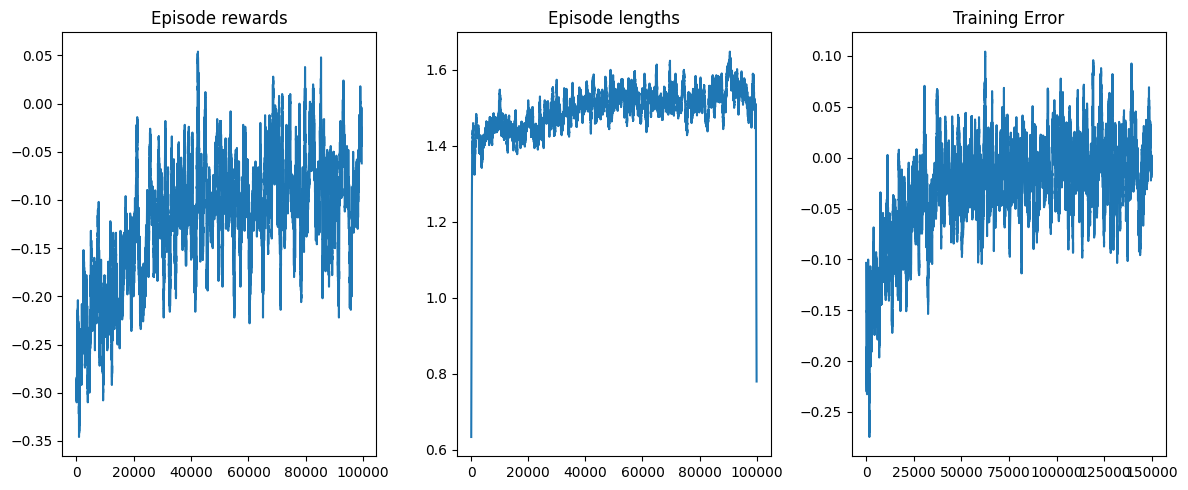

In [42]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error),
                np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)),
            training_error_moving_average)
plt.tight_layout()
plt.show()


In [43]:
env.render()

/Users/hwcrane/.local/lib/python3.11/site-packages/gymnasium/envs/toy_text/blackjack.py:229: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("Blackjack-v1", render_mode="rgb_array")
  gym.logger.warn(
